# Amazon Braket で Qiskit を実行する

In [1]:
# このノートブックの実行料金を見積もるために Braket SDK Cost Tracking を使用します
from braket.tracking import Tracker
t = Tracker().start()

お客様も、ここ数年で量子コンピュータを学んだ多くの方と同じように、2017 年に初めてリリースされたオープンソースの量子ソフトウェア開発キット (SDK) である Qiskit を使って、量子回路をプログラミングする方法を学んだかもしれません。
[Qiskit-Braket provider](https://github.com/qiskit-community/qiskit-braket-provider/blob/main/docs/tutorials/0_tutorial_qiskit-braket-provider_overview.ipynb) を使えば、[Amazon Braket](https://aws.amazon.com/braket/) のゲートベースのデバイスのどれを使っても、Qiskit のコードを実行できます。

**注意** ローカル環境でこのノートブックを実行している場合 (つまりBraket コンソールから実行していない場合)、Braket デバイスにアクセスするために、最初に AWS アカウントが適切に構成されていることを確認する必要があります。[こちらのチュートリアル](https://aws.amazon.com/blogs/quantum-computing/setting-up-your-local-development-environment-in-amazon-braket/)で、その手順をご確認ください。

## Qiskit から Braket デバイスにアクセスする

Amazon Braket のバックエンドデバイスはかなり種類が多いため、それぞれのおすすめユースケースを 1 つずつ説明していきます。

### 量子シミュレータ

まず、ローカルシミュレータから始めましょう。これはローカル環境で動作する量子フル状態ベクトルシミュレータです。ローカル環境とは、この Jupyter ノートブックの実行場所 (例えば、ローカル開発環境や Braket コンソール上のノートブックインスタンスなど) を指します。

**推奨ユースケース:** 最大 12 量子ビットのノイズなし回路

In [2]:
from qiskit_braket_provider import BraketLocalBackend

local_simulator = BraketLocalBackend()

次に、ローカル密度行列シミュレータです。このシミュレータもローカル環境で動作しますが、量子回路に対するノイズの影響をシミュレートできます。密度行列は状態ベクトルの 2 倍の大きさなので、効果的にシミュレートできる量子ビット数は、ローカル状態ベクトルシミュレータの半分になります。

**推奨ユースケース :** 最大 6 量子ビットのノイズあり回路

In [3]:
local_dm_simulator = BraketLocalBackend(name='braket_dm')

Braket オンデマンドシミュレータは、AWS のコンピューティングリソース上で動作し、ローカルシミュレータの機能に加え、いくつかの拡張機能を備えています。以下のコードで、利用可能な Braket のシミュレータをすべてリストアップすることができます。

In [4]:
from qiskit_braket_provider import AWSBraketProvider

provider = AWSBraketProvider()

provider.backends(statuses=["ONLINE"], types=["SIMULATOR"])

[BraketBackend[SV1], BraketBackend[TN1], BraketBackend[dm1]]

オンデマンドシミュレータの 1 つめは SV1 です。これはフル状態ベクトルシミュレータで、ローカルシミュレータよりも大規模な回路のシミュレーションが可能です。また、タスクをバッチ処理して並列実行する機能とともに、変分量子アルゴリズムの adjoint 勾配計算などの応用テクニックも使用できます。

**推奨ユースケース :** 最大 34 量子ビットのノイズなし変分アルゴリズム

In [5]:
aws_sv1 = provider.get_backend("SV1")

2 つめのオンデマンドシミュレータは DM1 です。これは密度行列シミュレータで、SV1 と同様に、より多くの量子ビットをシミュレートでき、バッチ実行も可能です。

**推奨ユースケース :** 最大 17 量子ビットのノイズあり変分アルゴリズム

In [6]:
aws_dm1 = provider.get_backend("dm1")

最後のオンデマンドシミュレータは TN1 です。これはテンソルネットワークシミュレータで、回路内の各ゲートをテンソルとして表現します。TN1 は、局所的なゲートやその他の特殊な構造を持つ回路では、より多くの量子ビットをシミュレートできますが、長距離のゲートや all-to-all のゲート構造を持つ回路に対しては、SV1 や DM1 よりも遅くなるのが普通です。

**推奨ユースケース :** 局所的な接続性を持ち、最大 50 量子ビットのノイズなし回路

**注意:** 各 AWS リソース (ファイル、CPU、QPUなど) は特定のリージョンにのみ存在し、そのリージョンからしかアクセスできない場合があります。例えば、TN1 は `eu-west-2`、 `us-east-1`、 `us-west-2` リージョンでのみ利用可能です。

マネージドノートブックで実行している場合に AWS リージョンを変更するには、AWS コンソールの右上から新しいリージョンを選択し、Braket コンソールからノートブックを再起動または作成する必要があります。

ローカル開発環境で実行している場合に AWS リージョンを変更するには、次のコードスニペットを実行します。
```
import os
os.environ["AWS_REGION"] = "your-desired-region"
```

In [9]:
# TN1 にアクセスできるリージョンの 1 つに切り替えた場合は、次のコードのコメントを自由に解除できます。
# aws_tn1 = provider.get_backend("TN1")

### 量子処理ユニット (QPU)

Amazon Braket では、多くのサードパーティ製量子ハードウェアデバイスへのアクセスも可能です。以下のコードは、現在オンラインの、サポートされている QPU を表示します。

In [10]:
provider.backends(statuses=["ONLINE"], types=["QPU"])

[BraketBackend[Aspen-M-3], BraketBackend[Harmony]]

各量子コンピュータの詳細については、Braket ホームページの [Providers Overview](https://aws.amazon.com/braket/quantum-computers/)、または Braket コンソールの左側にある Devices タブから確認できます。
現在、Qiskit-Braket プロバイダでサポートされているのは、ゲートベースのQPU (IonQ, OQC, Rigetti) のみです。

## Braket デバイス上で回路を実行する

Qiskit-Braket プロバイダで利用可能な量子デバイスについて説明したので、実際に使ってみましょう！今回の例では、Rigetti デバイスで 3 量子 GHZ 状態を作成しますが、以下のコメントアウトされたデバイスから自由に別の QPU を選択できます。

In [11]:
qpu_backend = provider.get_backend("Aspen-M-3")
# qpu_backend = provider.get_backend("Lucy")
# qpu_backend = provider.get_backend("Aria 1")

print(qpu_backend)

BraketBackend[Aspen-M-3]


In [12]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(0, 2)
circuit.draw()

┌───┐          
q_0: ┤ H ├──■────■──
     └───┘┌─┴─┐  │  
q_1: ─────┤ X ├──┼──
          └───┘┌─┴─┐
q_2: ──────────┤ X ├
               └───┘

In [13]:
# run circuit
qpu_task = qpu_backend.run(circuit, shots=10)

実行したタスクには、それぞれ固有の ARN（Amazon Resource Name）が割り当てられ、これを保存しておくことで、タスク実行後にノートブックを閉じても、タスクのデータを取得することができます。

In [14]:
task_id = qpu_task.job_id()
task_id

'arn:aws:braket:us-west-1:700863243650:quantum-task/1f41ab60-ed25-4352-8d2d-28b6772d94ee'

**注意 :** Amazon Braket で「タスク (task)」と呼ばれるものを、Qiskit は「ジョブ (job)」という名称で使用しています。`.job_id()` を呼び出すことで、タスクの ARN にアクセスできるのはこのためです。

一方で、Braket には「ハイブリッドジョブ (Hybrid Jobs)」と呼ばれる別の機能があります。この機能は今回のノートブックの範囲を超えていますが、[開発者ガイド](https://docs.aws.amazon.com/braket/latest/developerguide/braket-jobs.html)で読むことができます。

In [15]:
# タスクデータの取得
retrieved_task = qpu_backend.retrieve_job(job_id=task_id)

その後、タスクが終了したかどうかステータスで確認できます。

In [22]:
retrieved_task.status()

<JobStatus.DONE: 'job has successfully run'>

**注意:** デバイスによって、利用可能な時間帯は異なります。そのためタスクはすぐに実行されないかもしれませんが、キューに追加され、デバイスがオンラインに戻った時に実行されますので、ご安心ください。

タスクが終了したら、データを取得できます。

In [23]:
data = retrieved_task.result()

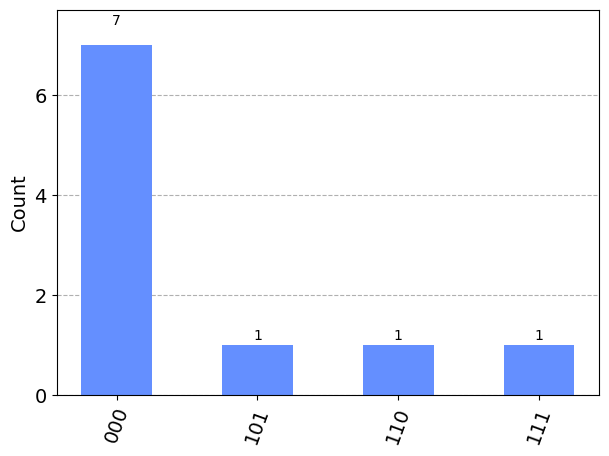

In [24]:
from qiskit.visualization import plot_histogram
plot_histogram(data.get_counts())

## Braket デバイス上でアルゴリズムを実行する

さらに、Qiskit-Braket provider を使用して、Braket バックエンド上で組み込みの Qiskit アルゴリズムを実行できます。例えば、水素の基底状態を見つけるために VQE アルゴリズムを実行できます。この問題は少ない量子ビットしか必要としない基底で表現でき、素早く実行できるので、ローカルシミュレータを使用します。

In [26]:
from qiskit.opflow import (
    I,
    X,
    Z,
)

# H2 のハミルトニアン演算子を Pauli スピン演算子で定義します。
H2_op = (
    (-1.052373245772859 * I ^ I)
    + (0.39793742484318045 * I ^ Z)
    + (-0.39793742484318045 * Z ^ I)
    + (-0.01128010425623538 * Z ^ Z)
    + (0.18093119978423156 * X ^ X)
)

In [27]:
# ライブラリのインポート
from qiskit.utils import QuantumInstance
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import SLSQP
from qiskit.algorithms import VQE

# Braket バックエンドで `QuantumInstance` を定義します。
qi = QuantumInstance(local_simulator, seed_transpiler=42, seed_simulator=42)

# VQE の設定
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
slsqp = SLSQP(maxiter=1)
vqe = VQE(ansatz, optimizer=slsqp, quantum_instance=qi)

# 基底状態を見つけます。
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 9,
    'eigenstate': {   '00': 0.12103072956898178,
                      '01': 0.11692679333668567,
                      '10': 0.10825317547305482,
                      '11': 0.9797759629119301},
    'eigenvalue': (-1.0889057236530086+0j),
    'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): -5.755436545071434,
                              ParameterVectorElement(θ[1]): -0.06350247974205825,
                              ParameterVectorElement(θ[7]): -5.525501547721888,
                              ParameterVectorElement(θ[4]): -5.425306283034111,
                              ParameterVectorElement(θ[0]): -2.9712537272548736,
                              ParameterVectorElement(θ[6]): 4.055161926547246,
                              ParameterVectorElement(θ[5]): -4.2635679526293035,
                              ParameterVectorElement(θ[2]): -3.5371159105090197},
    'optimal_point

## 今後のアクション

可能性は無限大です！Qiskit-Braket provider はまだ新しく実験的なものなので、バグに遭遇した場合や新機能をサポートしたい場合は、[GitHub に issue を提出](https://github.com/qiskit-community/qiskit-braket-provider/issues)し、feature ブランチを作って開発に参加してみてください！

In [28]:
print("Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.2f} USD")

Task Summary
{'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-3': {'shots': 10, 'tasks': {'COMPLETED': 1}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.30 USD
